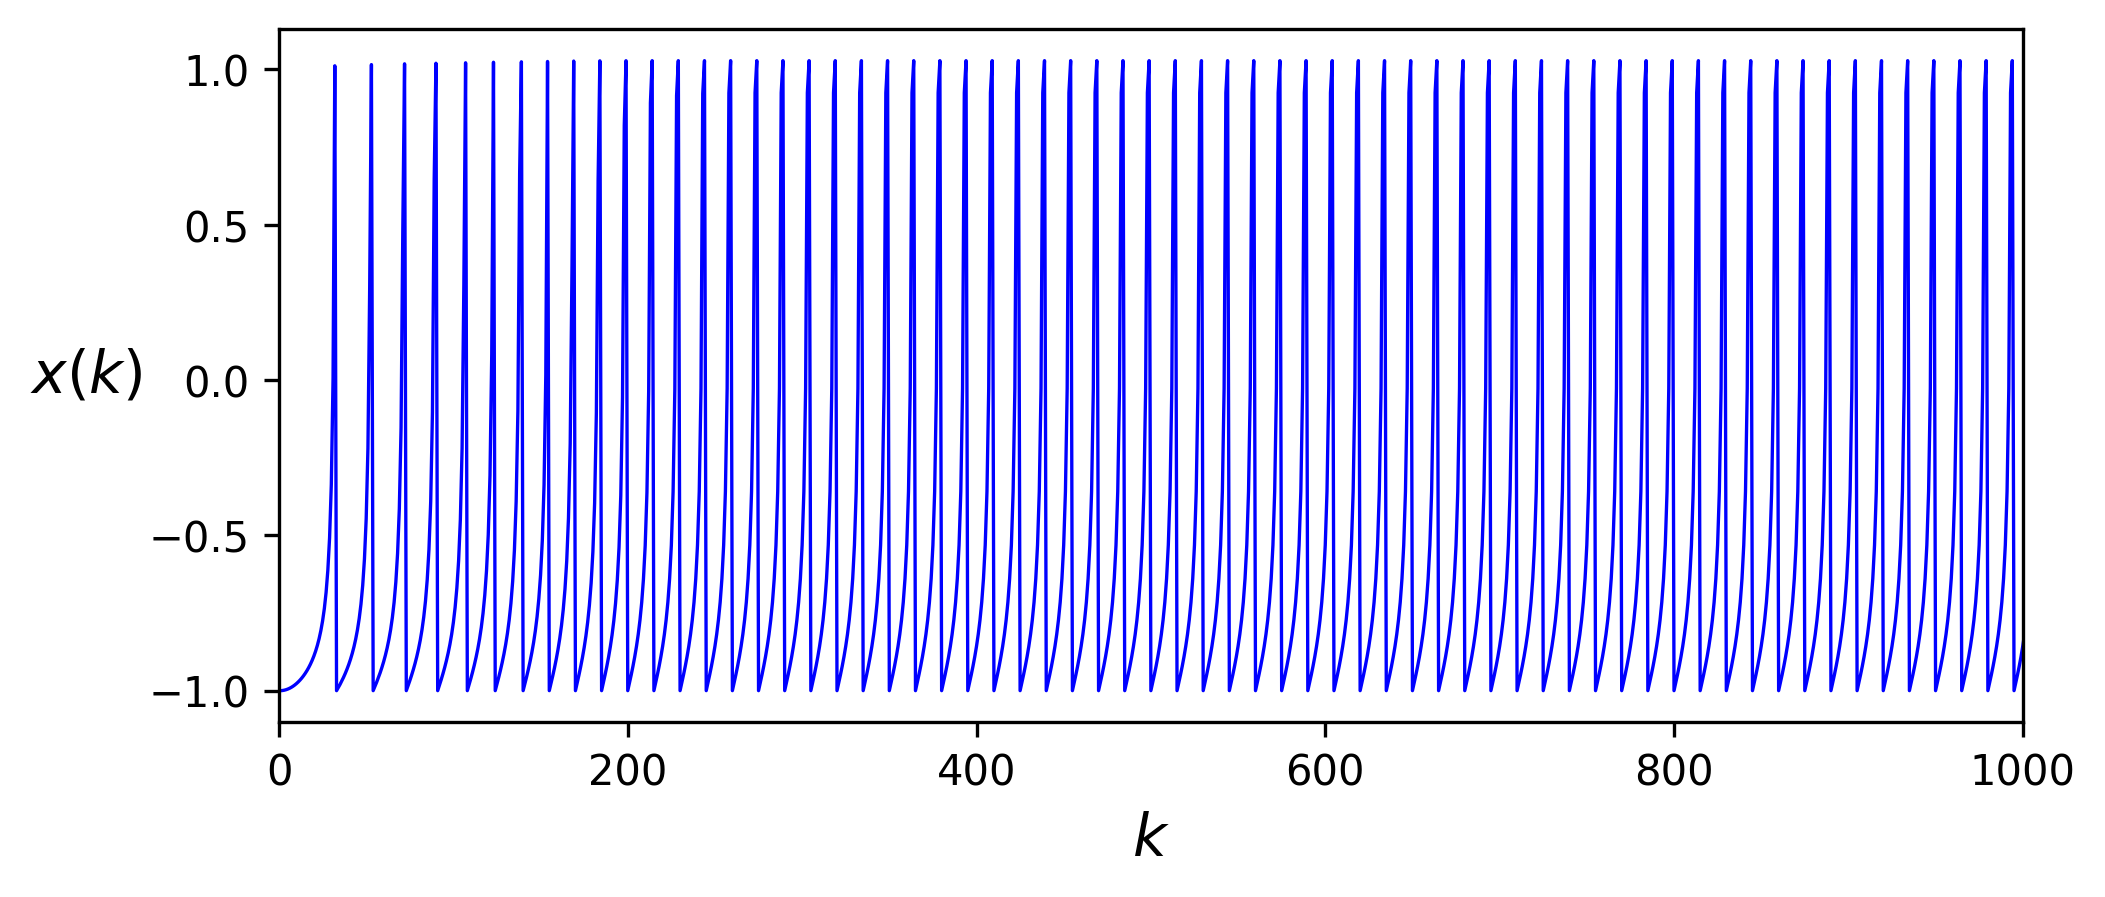

In [4]:
# Basic

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

def fast_rulkov_map(x, y, alpha):
    if x <= 0:
        x_iter = alpha / (1 - x) + y
    elif 0 < x < (alpha + y):
        x_iter = alpha + y
    elif x >= (alpha + y):
        x_iter = -1
    return x_iter

def rulkov_map(x, y, sigma, alpha, mu):
    x_iter = fast_rulkov_map(x, y, alpha)
    y_iter = y - mu * (x - sigma)
    return [x_iter, y_iter]

def generate_orbit_rulkov(sigma, alpha, mu, initial_state, num_iterations):
    orbit = [initial_state]
    state = initial_state

    for _ in range(num_iterations):
        state = rulkov_map(state[0], state[1], sigma, alpha, mu)
        orbit.append(state)
    
    orbit = np.asarray(orbit)
    return orbit

def graph_rulkov_neuron_behavior(orbit):
    x, y = orbit.T
    plt.figure(figsize=(7.5, 3))
    plt.plot(x, color='blue', linewidth = 0.8)
    plt.xlabel(r'$k$', fontsize=14)
    plt.ylabel(r'$x(k)$', rotation='horizontal', va='center', labelpad=15, fontsize=14)
    plt.xlim(0, 1000)

alpha = 4
mu = 0.001
sigma = -0.5
initial_state = [-1, -3]
num_iterations = 10000

orbit = generate_orbit_rulkov(sigma, alpha, mu, initial_state, num_iterations)
graph_rulkov_neuron_behavior(orbit)

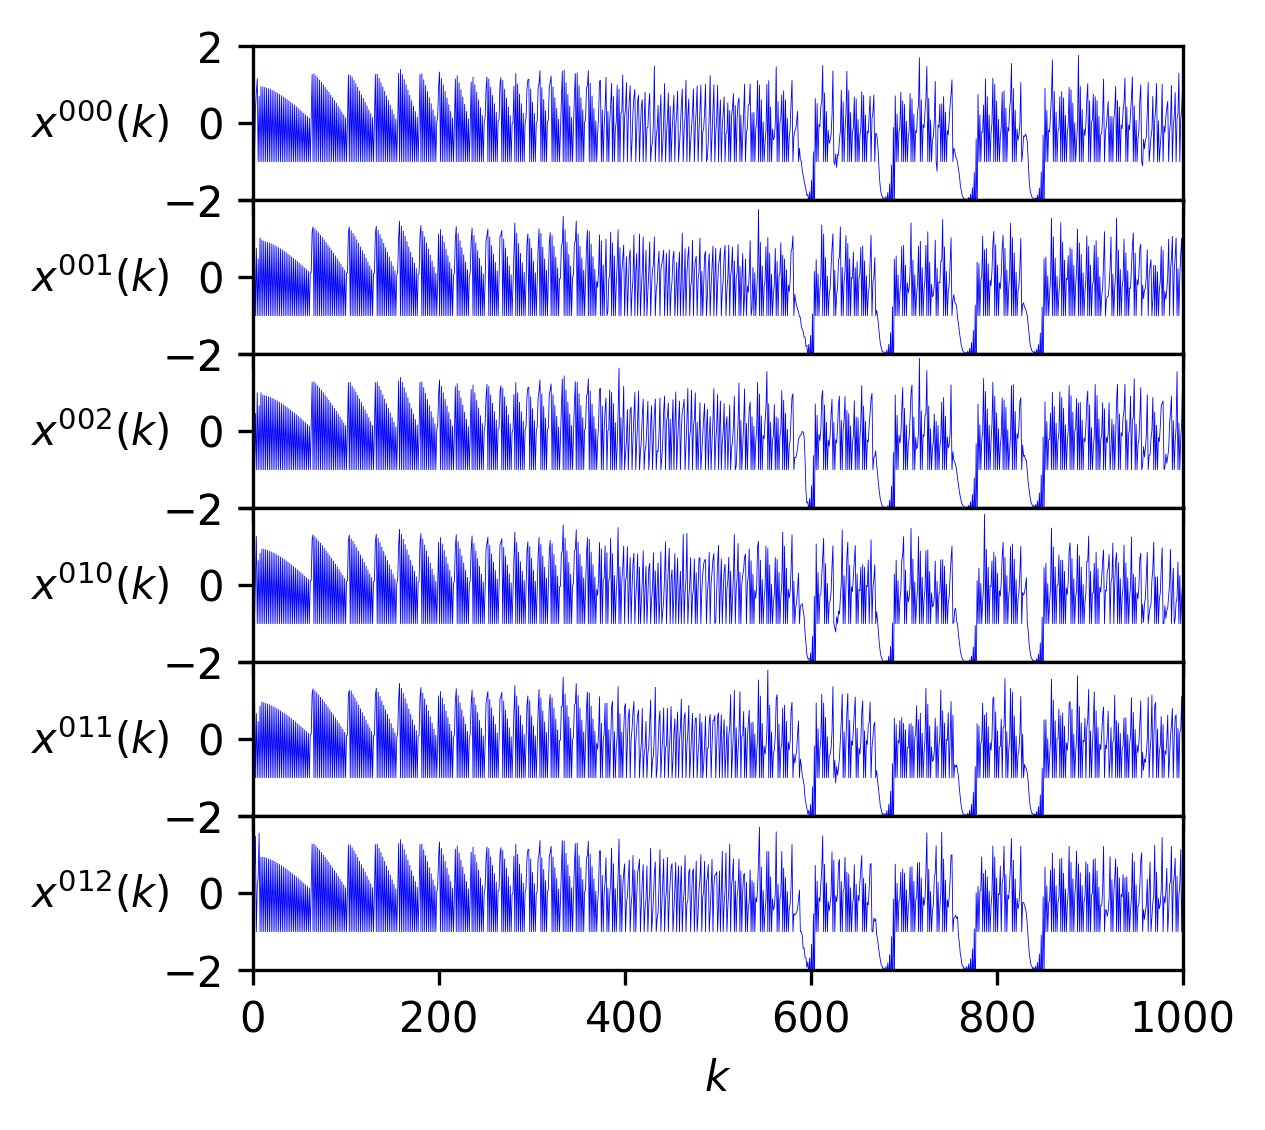

In [ ]:
# NN

import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

def coordinate_to_neuron_index(coordinate):
    return sum(coordinate[k - 1] * zeta ** (N - k) for k in range(1, N + 1))

def neuron_index_to_coordinate(index):
    coordinate = []
    for k in range(N):
        power = zeta ** (N - k - 1)
        digit = index // power
        coordinate.append(digit)
        index = index % power
    return coordinate

def I(coordinate, a):
    return 2 * coordinate_to_neuron_index(coordinate) + a

def I_inverse(vector_index):
    a = vector_index % 2
    coord_index = vector_index // 2
    coordinate = neuron_index_to_coordinate(coord_index)
    return coordinate, a

def rulkov_map_coupling(neuron, coupling_param_x, coupling_param_y, sigma, alpha, mu):
    x = neuron[0]
    y = neuron[1]
    x_iter = fast_rulkov_map(x, y + coupling_param_x, alpha)
    y_iter = y - mu * x + mu * (sigma + coupling_param_y)
    return [x_iter, y_iter]

def NN_set_of_influence(neuron_index):
    coordinate = neuron_index_to_coordinate(neuron_index)
    set_of_influence = []
    for i in range(N):
        above_coord = coordinate.copy()
        below_coord = coordinate.copy()
        above_coord[i] = (above_coord[i] + 1) % zeta
        below_coord[i] = (below_coord[i] - 1) % zeta
        above_index = coordinate_to_neuron_index(above_coord)
        below_index = coordinate_to_neuron_index(below_coord)
        set_of_influence.append(above_index)
        set_of_influence.append(below_index)
    return set_of_influence

def NN_coup_params(system_state, g):
    coup_params = np.zeros(zeta ** N)
    for i in range(zeta ** N):
        external_voltages = sum(system_state[j][0] for j in NN_set_of_influence(i))
        coup_params[i] = g / (2 * N) * (external_voltages - 2 * N * system_state[i][0])
    return coup_params

def iterate_lattice(system_state, g, sigma_vals, alpha_vals, mu): # Coupling type dependent
    coup_params = NN_coup_params(system_state, g)
    system_state_iter = []
    for i in range(zeta ** N):
        neuron_iter = rulkov_map_coupling(system_state[i], coup_params[i], coup_params[i], sigma_vals[i], alpha_vals[i], mu)
        system_state_iter.append(neuron_iter)
    return system_state_iter

def generate_lattice_orbit(initial_system_state, g, sigma_vals, alpha_vals, mu, num_iterations):
    lattice_orbit = [initial_system_state]
    system_state = initial_system_state
    for _ in range(num_iterations):
        system_state = iterate_lattice(system_state, g, sigma_vals, alpha_vals, mu)
        lattice_orbit.append(system_state)
    lattice_orbit = np.asarray(lattice_orbit)
    return lattice_orbit

def NN_jacobian(system_state, g, alpha_vals, mu):
    J = np.zeros((2 * zeta ** N, 2 * zeta ** N))
    coup_params = NN_coup_params(system_state, g)
    # i_ represents the i prime neuron index
    for i_ in range(zeta ** N):
        i_0 = 2 * i_ # the state vector index of the fast variable of the i prime neuron
        i_1 = 2 * i_ + 1 # the state vector index of the slow variable of the i prime neuron
        i_stars = NN_set_of_influence(i_) # set of influence
        x = system_state[i_][0]
        y = system_state[i_][1]
        alpha = alpha_vals[i_]
        D = alpha + y + coup_params[i_]

        J[i_1][i_1] = 1
        J[i_1][i_0] = -mu * (1 + g)
        for i in i_stars:
            i_star0 = 2 * i
            J[i_1][i_star0] = mu * g / 2 / N
        if x < D:
            J[i_0][i_1] = 1
            for i in i_stars:
                i_star0 = 2 * i
                J[i_0][i_star0] = g / 2 / N
            if x <= 0:
                J[i_0][i_0] = alpha / (1 - x) / (1 - x) - g
            elif 0 < x < D:
                J[i_0][i_0] = - g

    return J

def generate_lattice_jacobians(lattice_orbit, g, alpha_vals, mu): # Coupling type dependent
    J_matrices = []
    for k in range(len(lattice_orbit)):
        J_matrices.append(NN_jacobian(lattice_orbit[k], g, alpha_vals, mu))
    return J_matrices

def qr_lyap_rulkov_two_coup(J_matrices):
    QR = [[np.zeros((2 * zeta ** N, 2 * zeta ** N)), np.zeros((2 * zeta ** N, 2 * zeta ** N))]]
    QR.append(np.linalg.qr(J_matrices[0]))
    for k in range(2, len(J_matrices)):
        J_star = np.matmul(J_matrices[k - 1], QR[k - 1][0])
        QR.append(np.linalg.qr(J_star))
    lyapunov_sums = np.zeros(2 * zeta ** N)
    for k in range(1, len(QR)):
        for j in range(2 * zeta ** N):
            lyapunov_sums[j] = lyapunov_sums[j] + np.log(np.absolute(QR[k][1][j][j]))
    lyapunov_spectrum = lyapunov_sums / (len(QR) - 1)
    lyapunov_spectrum = list(reversed(np.sort(lyapunov_spectrum)))
    return lyapunov_spectrum

def first_lyapunov_exponent_renorm(J_matrices, renorm_interval=1):
    dim = J_matrices[0].shape[0]
    v = np.random.rand(dim)
    v = v / np.linalg.norm(v)
    total_log_norm = 0.0
    count = 0

    for i in range(0, len(J_matrices)):
        v = J_matrices[i] @ v
        if (i + 1) % renorm_interval == 0:
            norm = np.linalg.norm(v)
            v = v / norm
            total_log_norm += np.log(norm)
            count += 1

    return total_log_norm / count
    
def graph_some_lattice_neuron_orbits(lattice_orbit):
    neuron_0_orbit_x = lattice_orbit.T[0][0] %LAST NUMBER IS INDEX
    neuron_1_orbit_x = lattice_orbit.T[0][1]
    neuron_2_orbit_x = lattice_orbit.T[0][2]
    neuron_3_orbit_x = lattice_orbit.T[0][3]
    neuron_4_orbit_x = lattice_orbit.T[0][4]
    neuron_5_orbit_x = lattice_orbit.T[0][5]
    fig, axs = plt.subplots(6, sharex=True, figsize=(4, 4))
    axs[0].plot(neuron_0_orbit_x, color='blue', linewidth = 0.2)
    axs[0].set_ylabel(r'$x^{000}(k)$', rotation='horizontal', va='center', labelpad=15) %EXPONENT IS COORDINATE IN LATTICE
    axs[0].set_xlim(0, 1000)
    axs[0].set_ylim(-2, 2)
    axs[1].plot(neuron_1_orbit_x, color='blue', linewidth = 0.2)
    axs[1].set_ylabel(r'$x^{001}(k)$', rotation='horizontal', va='center', labelpad=15)
    axs[1].set_xlim(0, 1000)
    axs[1].set_ylim(-2, 2)
    axs[2].plot(neuron_2_orbit_x, color='blue', linewidth = 0.2)
    axs[2].set_ylabel(r'$x^{002}(k)$', rotation='horizontal', va='center', labelpad=15)
    axs[2].set_xlim(0, 1000)
    axs[2].set_ylim(-2, 2)
    axs[3].plot(neuron_3_orbit_x, color='blue', linewidth = 0.2)
    axs[3].set_ylabel(r'$x^{010}(k)$', rotation='horizontal', va='center', labelpad=15)
    axs[3].set_xlim(0, 1000)
    axs[3].set_ylim(-2, 2)
    axs[4].plot(neuron_4_orbit_x, color='blue', linewidth = 0.2)
    axs[4].set_ylabel(r'$x^{011}(k)$', rotation='horizontal', va='center', labelpad=15)
    axs[4].set_xlim(0, 1000)
    axs[4].set_ylim(-2, 2)
    axs[5].plot(neuron_5_orbit_x, color='blue', linewidth = 0.2)
    axs[5].set_ylabel(r'$x^{012}(k)$', rotation='horizontal', va='center', labelpad=15)
    axs[5].set_xlim(0, 1000)
    axs[5].set_ylim(-2, 2)
    plt.xlabel(r'$k$')
    plt.subplots_adjust(hspace=0)
    plt.show()

np.random.seed(42)

# set the lattice dimension:
N = 4

# set the number of neurons along a dimension (recall zeta-th neuron = 1st neuron on tordoid BC):
zeta = 4

# set the conductance: 
g = 1

# set the slow oscillation amplitude:
mu = 0.001

# set the number of simulation timesteps:
num_iterations = 2000

initial_x_states = np.random.uniform(-1, 1, zeta ** N)
initial_y_states = np.repeat(-3.25, zeta ** N)
initial_system_state = np.column_stack((initial_x_states, initial_y_states))

'''Homogeneous'''
sigma_vals = np.repeat(-0.5, zeta ** N)
alpha_vals = np.repeat(4.5, zeta ** N)

'''Partially heterogeneous'''
#sigma_vals = np.random.uniform(-1.5, -0.5, zeta ** N)
#alpha_vals = np.repeat(4.5, zeta ** N)

'''Fully heterogeneous'''
#sigma_vals = np.random.uniform(-1.5, -0.5, zeta ** N)
#alpha_vals = np.random.uniform(4.25, 4.75, zeta ** N)

start_time = time.time()

lattice_orbit = generate_lattice_orbit(initial_system_state, g, sigma_vals, alpha_vals, mu, num_iterations)
graph_some_lattice_neuron_orbits(lattice_orbit)
J_matrices = generate_lattice_jacobians(lattice_orbit, g, alpha_vals, mu)
#lyapunov_spectrum = qr_lyap_rulkov_two_coup(J_matrices)
#print(lyapunov_spectrum[0])
lyap1 = first_lyapunov_exponent_renorm(J_matrices)
print(lyap1)

print(f"> Execution of loop took: {time.time() - start_time} seconds")

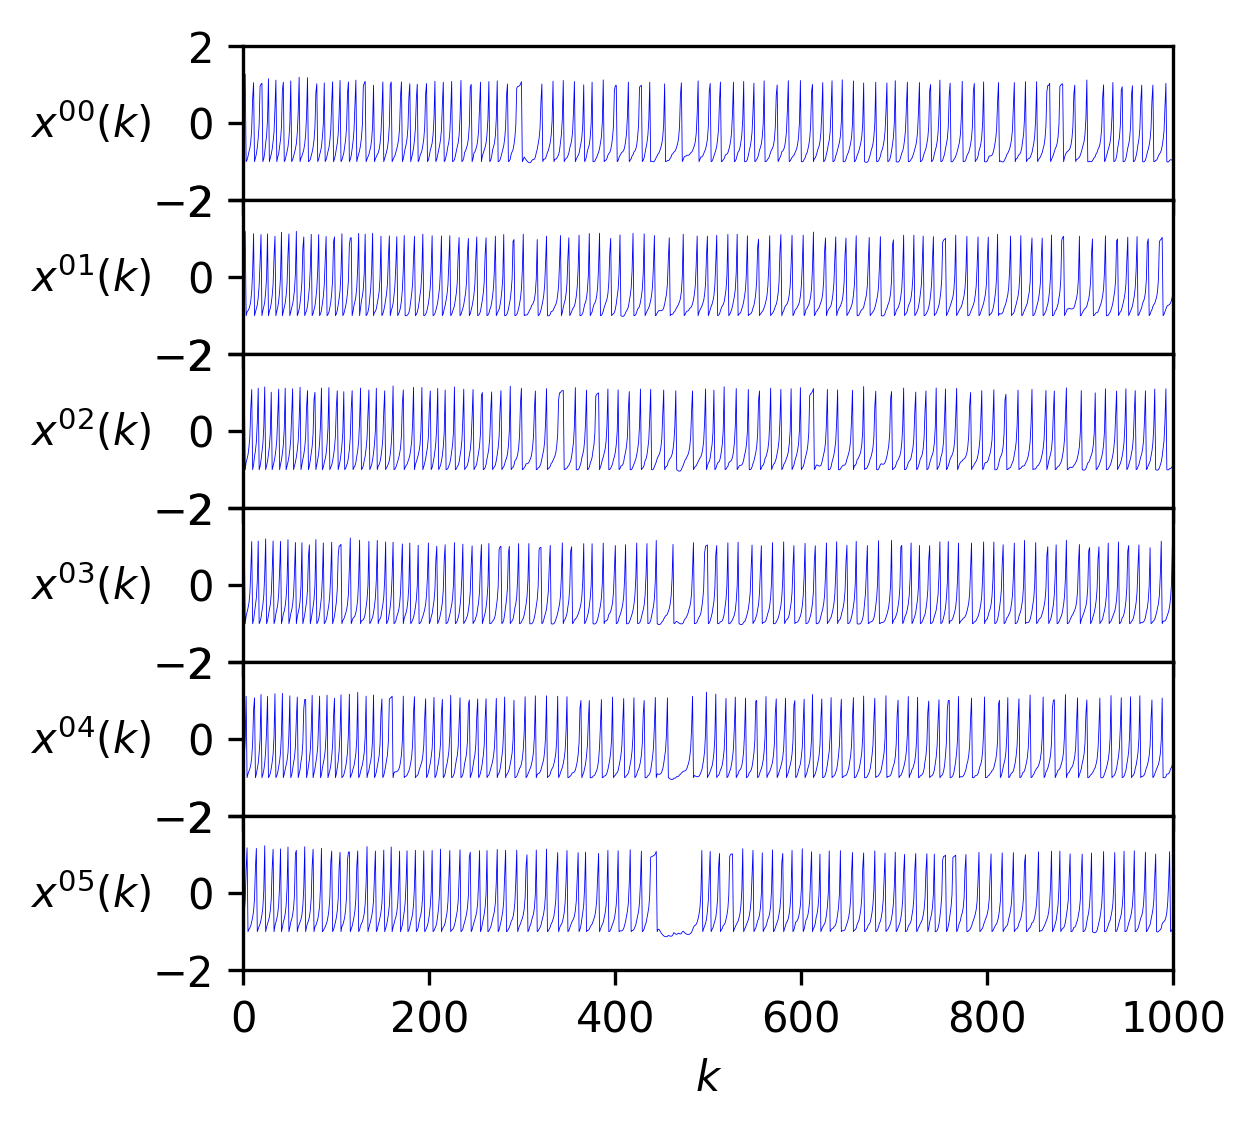

0.1924506789024884
> Execution of loop took: 4.442582845687866 seconds


In [4]:
# NNN

import time
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

def fast_rulkov_map(x, y, alpha):
    if x <= 0:
        x_iter = alpha / (1 - x) + y
    elif 0 < x < (alpha + y):
        x_iter = alpha + y
    elif x >= (alpha + y):
        x_iter = -1
    return x_iter

def rulkov_map(x, y, sigma, alpha, mu):
    x_iter = fast_rulkov_map(x, y, alpha)
    y_iter = y - mu * (x - sigma)
    return [x_iter, y_iter]

def generate_orbit_rulkov(sigma, alpha, mu, initial_state, num_iterations):
    orbit = [initial_state]
    state = initial_state

    for _ in range(num_iterations):
        state = rulkov_map(state[0], state[1], sigma, alpha, mu)
        orbit.append(state)
    
    orbit = np.asarray(orbit)
    return orbit

def graph_rulkov_neuron_behavior(orbit):
    x, y = orbit.T
    plt.figure(figsize=(7.5, 3))
    plt.plot(x, color='blue', linewidth = 0.8)
    plt.xlabel(r'$k$', fontsize=14)
    plt.ylabel(r'$x(k)$', rotation='horizontal', va='center', labelpad=15, fontsize=14)
    plt.xlim(0, 1000)

def coordinate_to_neuron_index(coordinate):
    return sum(coordinate[k - 1] * zeta ** (N - k) for k in range(1, N + 1))

def neuron_index_to_coordinate(index):
    coordinate = []
    for k in range(N):
        power = zeta ** (N - k - 1)
        digit = index // power
        coordinate.append(digit)
        index = index % power
    return coordinate

def I(coordinate, a):
    return 2 * coordinate_to_neuron_index(coordinate) + a

def I_inverse(vector_index):
    a = vector_index % 2
    coord_index = vector_index // 2
    coordinate = neuron_index_to_coordinate(coord_index)
    return coordinate, a

def rulkov_map_coupling(neuron, coupling_param_x, coupling_param_y, sigma, alpha, mu):
    x = neuron[0]
    y = neuron[1]
    x_iter = fast_rulkov_map(x, y + coupling_param_x, alpha)
    y_iter = y - mu * x + mu * (sigma + coupling_param_y)
    return [x_iter, y_iter]

def NNN_set_of_influence(neuron_index):
    coordinate = neuron_index_to_coordinate(neuron_index)
    set_of_influence = []
    for i in range(N):
        above_coord = coordinate.copy()
        below_coord = coordinate.copy()
        above_coord_2 = coordinate.copy()
        below_coord_2 = coordinate.copy()
        above_coord[i] = (above_coord[i] + 1) % zeta
        below_coord[i] = (below_coord[i] - 1) % zeta
        above_coord_2[i] = (above_coord_2[i] + 2) % zeta
        below_coord_2[i] = (below_coord_2[i] - 2) % zeta
        above_index = coordinate_to_neuron_index(above_coord)
        below_index = coordinate_to_neuron_index(below_coord)
        above_index_2 = coordinate_to_neuron_index(above_coord_2)
        below_index_2 = coordinate_to_neuron_index(below_coord_2)
        set_of_influence.append(above_index)
        set_of_influence.append(below_index)
        set_of_influence.append(above_index_2)
        set_of_influence.append(below_index_2)
    return set_of_influence

def NNN_coup_params(system_state, g):
    coup_params = np.zeros(zeta ** N)
    for i in range(zeta ** N):
        external_voltages = sum(system_state[j][0] for j in NNN_set_of_influence(i))
        coup_params[i] = g / (4 * N) * (external_voltages - 4 * N * system_state[i][0])
    return coup_params

def iterate_lattice(system_state, g, sigma_vals, alpha_vals, mu): # Coupling type dependent
    coup_params = NNN_coup_params(system_state, g)
    system_state_iter = []
    for i in range(zeta ** N):
        neuron_iter = rulkov_map_coupling(system_state[i], coup_params[i], coup_params[i], sigma_vals[i], alpha_vals[i], mu)
        system_state_iter.append(neuron_iter)
    return system_state_iter

def generate_lattice_orbit(initial_system_state, g, sigma_vals, alpha_vals, mu, num_iterations):
    lattice_orbit = [initial_system_state]
    system_state = initial_system_state
    for _ in range(num_iterations):
        system_state = iterate_lattice(system_state, g, sigma_vals, alpha_vals, mu)
        lattice_orbit.append(system_state)
    lattice_orbit = np.asarray(lattice_orbit)
    return lattice_orbit

def NNN_jacobian(system_state, g, alpha_vals, mu):
    J = np.zeros((2 * zeta ** N, 2 * zeta ** N))
    coup_params = NNN_coup_params(system_state, g)
    # i_ represents the i prime neuron index
    for i_ in range(zeta ** N):
        i_0 = 2 * i_ # the state vector index of the fast variable of the i prime neuron
        i_1 = 2 * i_ + 1 # the state vector index of the slow variable of the i prime neuron
        i_stars = NNN_set_of_influence(i_) # set of influence
        x = system_state[i_][0]
        y = system_state[i_][1]
        alpha = alpha_vals[i_]
        D = alpha + y + coup_params[i_]

        J[i_1][i_1] = 1
        J[i_1][i_0] = -mu * (1 + g)
        for i in i_stars:
            i_star0 = 2 * i
            J[i_1][i_star0] = mu * g / 4 / N
        if x < D:
            J[i_0][i_1] = 1
            for i in i_stars:
                i_star0 = 2 * i
                J[i_0][i_star0] = g / 4 / N
            if x <= 0:
                J[i_0][i_0] = alpha / (1 - x) / (1 - x) - g
            elif 0 < x < D:
                J[i_0][i_0] = - g

    return J

def generate_lattice_jacobians(lattice_orbit, g, alpha_vals, mu): # Coupling type dependent
    J_matrices = []
    for k in range(len(lattice_orbit)):
        J_matrices.append(NNN_jacobian(lattice_orbit[k], g, alpha_vals, mu))
    return J_matrices

def qr_lyap_rulkov_two_coup(J_matrices):
    QR = [[np.zeros((2 * zeta ** N, 2 * zeta ** N)), np.zeros((2 * zeta ** N, 2 * zeta ** N))]]
    QR.append(np.linalg.qr(J_matrices[0]))
    for k in range(2, len(J_matrices)):
        J_star = np.matmul(J_matrices[k - 1], QR[k - 1][0])
        QR.append(np.linalg.qr(J_star))
    lyapunov_sums = np.zeros(2 * zeta ** N)
    for k in range(1, len(QR)):
        for j in range(2 * zeta ** N):
            lyapunov_sums[j] = lyapunov_sums[j] + np.log(np.absolute(QR[k][1][j][j]))
    lyapunov_spectrum = lyapunov_sums / (len(QR) - 1)
    lyapunov_spectrum = list(reversed(np.sort(lyapunov_spectrum)))
    return lyapunov_spectrum

def first_lyapunov_exponent_renorm(J_matrices, renorm_interval=1):
    dim = J_matrices[0].shape[0]
    v = np.random.rand(dim)
    v = v / np.linalg.norm(v)
    total_log_norm = 0.0
    count = 0

    for i in range(0, len(J_matrices)):
        v = J_matrices[i] @ v
        if (i + 1) % renorm_interval == 0:
            norm = np.linalg.norm(v)
            v = v / norm
            total_log_norm += np.log(norm)
            count += 1

    return total_log_norm / count
    
def graph_some_lattice_neuron_orbits(lattice_orbit):
    neuron_0_orbit_x = lattice_orbit.T[0][0]
    neuron_1_orbit_x = lattice_orbit.T[0][1]
    neuron_2_orbit_x = lattice_orbit.T[0][2]
    neuron_3_orbit_x = lattice_orbit.T[0][3]
    neuron_4_orbit_x = lattice_orbit.T[0][4]
    neuron_5_orbit_x = lattice_orbit.T[0][5]
    fig, axs = plt.subplots(6, sharex=True, figsize=(4, 4))
    axs[0].plot(neuron_0_orbit_x, color='blue', linewidth = 0.2)
    axs[0].set_ylabel(r'$x^{00}(k)$', rotation='horizontal', va='center', labelpad=15)
    axs[0].set_xlim(0, 1000)
    axs[0].set_ylim(-2, 2)
    axs[1].plot(neuron_1_orbit_x, color='blue', linewidth = 0.2)
    axs[1].set_ylabel(r'$x^{01}(k)$', rotation='horizontal', va='center', labelpad=15)
    axs[1].set_xlim(0, 1000)
    axs[1].set_ylim(-2, 2)
    axs[2].plot(neuron_2_orbit_x, color='blue', linewidth = 0.2)
    axs[2].set_ylabel(r'$x^{02}(k)$', rotation='horizontal', va='center', labelpad=15)
    axs[2].set_xlim(0, 1000)
    axs[2].set_ylim(-2, 2)
    axs[3].plot(neuron_3_orbit_x, color='blue', linewidth = 0.2)
    axs[3].set_ylabel(r'$x^{03}(k)$', rotation='horizontal', va='center', labelpad=15)
    axs[3].set_xlim(0, 1000)
    axs[3].set_ylim(-2, 2)
    axs[4].plot(neuron_4_orbit_x, color='blue', linewidth = 0.2)
    axs[4].set_ylabel(r'$x^{04}(k)$', rotation='horizontal', va='center', labelpad=15)
    axs[4].set_xlim(0, 1000)
    axs[4].set_ylim(-2, 2)
    axs[5].plot(neuron_5_orbit_x, color='blue', linewidth = 0.2)
    axs[5].set_ylabel(r'$x^{05}(k)$', rotation='horizontal', va='center', labelpad=15)
    axs[5].set_xlim(0, 1000)
    axs[5].set_ylim(-2, 2)
    plt.xlabel(r'$k$')
    plt.subplots_adjust(hspace=0)
    plt.show()

np.random.seed(42)

# set the lattice dimension:
N = 2

# set the number of neurons along a dimension (recall zeta-th neuron = 1st neuron on tordoid BC):
zeta = 8

# set the conductance: 
g = 0.15

# set the slow oscillation amplitude:
mu = 0.001

# set the number of simulation timesteps:
num_iterations = 1000

initial_x_states = np.random.uniform(-1, 1, zeta ** N)
initial_y_states = np.repeat(-3.25, zeta ** N)
initial_system_state = np.column_stack((initial_x_states, initial_y_states))

'''Homogeneous'''
sigma_vals = np.repeat(-0.5, zeta ** N)
alpha_vals = np.repeat(4.5, zeta ** N)

'''Partially heterogeneous'''
#sigma_vals = np.random.uniform(-1.5, -0.5, zeta ** N)
#alpha_vals = np.repeat(4.5, zeta ** N)

'''Fully heterogeneous'''
#sigma_vals = np.random.uniform(-1.5, -0.5, zeta ** N)
#alpha_vals = np.random.uniform(4.25, 4.75, zeta ** N)

start_time = time.time()

lattice_orbit = generate_lattice_orbit(initial_system_state, g, sigma_vals, alpha_vals, mu, num_iterations)
graph_some_lattice_neuron_orbits(lattice_orbit)
J_matrices = generate_lattice_jacobians(lattice_orbit, g, alpha_vals, mu)
#lyapunov_spectrum = qr_lyap_rulkov_two_coup(J_matrices)
#print(lyapunov_spectrum[0])
lyap1 = first_lyapunov_exponent_renorm(J_matrices)
print(lyap1)

print(f"> Execution of loop took: {time.time() - start_time} seconds")

#plot_lattice_snapshots_in_grid(lattice_orbit, [315, 325, 335, 345, 355, 365, 375, 385, 395], columns=3)

In [ ]:
# Slice visualization

import matplotlib.pyplot as plt
import numpy as np

def plot_lattice_snapshots_in_grid(lattice_orbit, timestep_list, columns=5):
    rows = (len(timestep_list) + columns - 1) // columns 
    fig, axs = plt.subplots(rows, columns, figsize=(3 * columns, 3 * rows))

    axs = np.atleast_2d(axs)

    for idx, t in enumerate(timestep_list):
        row = idx // columns
        col = idx % columns
        voltages = lattice_orbit[t][:, 0]
        voltage_grid = voltages.reshape((zeta, zeta))
        im = axs[row][col].imshow(voltage_grid, cmap='gray', vmin=-2, vmax=2)
        axs[row][col].set_title(f"k = {t}", fontsize=20)
        axs[row][col].axis('off')

    for idx in range(len(timestep_list), rows * columns):
        row = idx // columns
        col = idx % columns
        axs[row][col].axis('off')

    plt.tight_layout()
    plt.show()

def plot_3d_lattice_slices(lattice_orbit, timestep_list, num_slices=5, center_slice=None, spacing=2):
    assert N == 3

    if center_slice is None:
        center_slice = zeta // 2

    half = num_slices // 2
    slice_offsets = [i * spacing for i in range(-half, half + 1)]
    slice_indices = [center_slice + offset for offset in slice_offsets if 0 <= center_slice + offset < zeta]

    time_steps = len(timestep_list)
    fig, axs = plt.subplots(time_steps, len(slice_indices), figsize=(len(slice_indices) * 2.2, time_steps * 2.2))
    axs = np.atleast_2d(axs)

    for row, t in enumerate(timestep_list):
        voltages = lattice_orbit[t][:, 0]
        voltage_3d = voltages.reshape((zeta, zeta, zeta))

        for col, slice_idx in enumerate(slice_indices):
            axs[row][col].imshow(voltage_3d[:, :, slice_idx], cmap='gray', vmin=-2, vmax=2)
            axs[row][col].axis('off')
            if row == 0:
                axs[row][col].set_title(f'$i_3={slice_idx}$', fontsize=24) 

        fig.text(0.09, 1 - (row + 1.1) / (time_steps + 0.65), f'$k={t}$', va='center', ha='center', rotation=90, fontsize=24)

    fig.tight_layout(rect=[0.05, 0, 1, 0.96]) 
    plt.subplots_adjust(left=0.1)
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8ff1dbde-5a19-4cc3-9c54-693b62f536f1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>